In [1]:
import os, glob, imageio, numpy as np, matplotlib.pyplot as plt, scipy
from tqdm import tqdm_notebook as tqdm

In [2]:
freq = 200

In [3]:
fname = glob.glob('web_{}hz*.avi'.format(freq))
fname = [x for x in fname if not 'spider' in x]
fname = fname[0]
fname

'web_200hz-009.avi'

In [4]:
fnameFFT = fname + '.fft.npy'
fnameFFT

'web_200hz-009.avi.fft.npy'

#### Convert video to npy

In [6]:
if os.path.exists(fname + '.npy'):
    data = np.load(fname + '.npy')
else:
    r = imageio.get_reader(fname)
    

    data = np.zeros((1024, 1024, r.get_length()), dtype=np.uint8)

    c = 0
    for f in tqdm(r.iter_data()):
        data[:, :, c] = np.mean(f, axis=2)
        c += 1

    np.save(fname + '.npy', data)

TypeError: 'float' object cannot be interpreted as an integer

#### Apply FFT

In [6]:
dataFFT = np.zeros(data.shape, dtype=np.complex64)

In [7]:
for x in tqdm(range(1024)):
    for y in range(1024):
        dataFFT[x,y,:] = scipy.fft(data[x,y,:])

In [8]:
np.save(fnameFFT, dataFFT)

In [9]:
del dataFFT;
import gc; gc.collect()

7

In [10]:
stop

NameError: name 'stop' is not defined

### Idea: Agglomerative clustering on FFT spectrum?

In [5]:
dataFFT = np.load(fnameFFT, mmap_mode='r')
dataFFT.shape

(1024, 1024, 10001)

In [6]:
idxSS = np.random.randint(0,1023,size=(1000,2),dtype=np.int64)
idxSS

array([[   9,  949],
       [1009,  758],
       [  76,  644],
       ...,
       [  44,  749],
       [ 672,  413],
       [ 722,  435]], dtype=int64)

In [7]:
# Create a 1000x1000 similarity matrix...
mtxDist = np.zeros((idxSS.shape[0] * (idxSS.shape[0]-1) //2,), dtype=np.float64)

c = 0
for i0 in tqdm(range(0, idxSS.shape[0])):
    for i1 in range(i0+1, idxSS.shape[0]):
        a = dataFFT[idxSS[i0,0], idxSS[i0,1], :]
        b = dataFFT[idxSS[i1,0], idxSS[i1,1], :]
        mtxDist[c] = np.linalg.norm(a - b)
        c += 1

In [8]:
samplesFit = np.abs(dataFFT[idxSS[:,0], idxSS[:,1], :])

In [9]:
fnameFFTflat = fnameFFT.replace('.npy', '') + '.flat.npy'

In [12]:
#dataFFTflat = np.abs(dataFFT.reshape((dataFFT.shape[0] * dataFFT.shape[1], -1))).astype(np.float32)
#np.save(fnameFFTflat, dataFFTflat)
dataFFTflat = np.load(fnameFFTflat)

In [11]:
del dataFFT; import gc; gc.collect()

NameError: name 'dataFFT' is not defined

In [13]:
import fastcluster, time
import scipy.spatial.distance, scipy.cluster.hierarchy
import matplotlib.pyplot as plt

In [14]:
t0 = time.time()
clust = fastcluster.linkage(mtxDist, method='ward', preserve_input=True)
t1 = time.time()
t1 - t0

0.031241178512573242

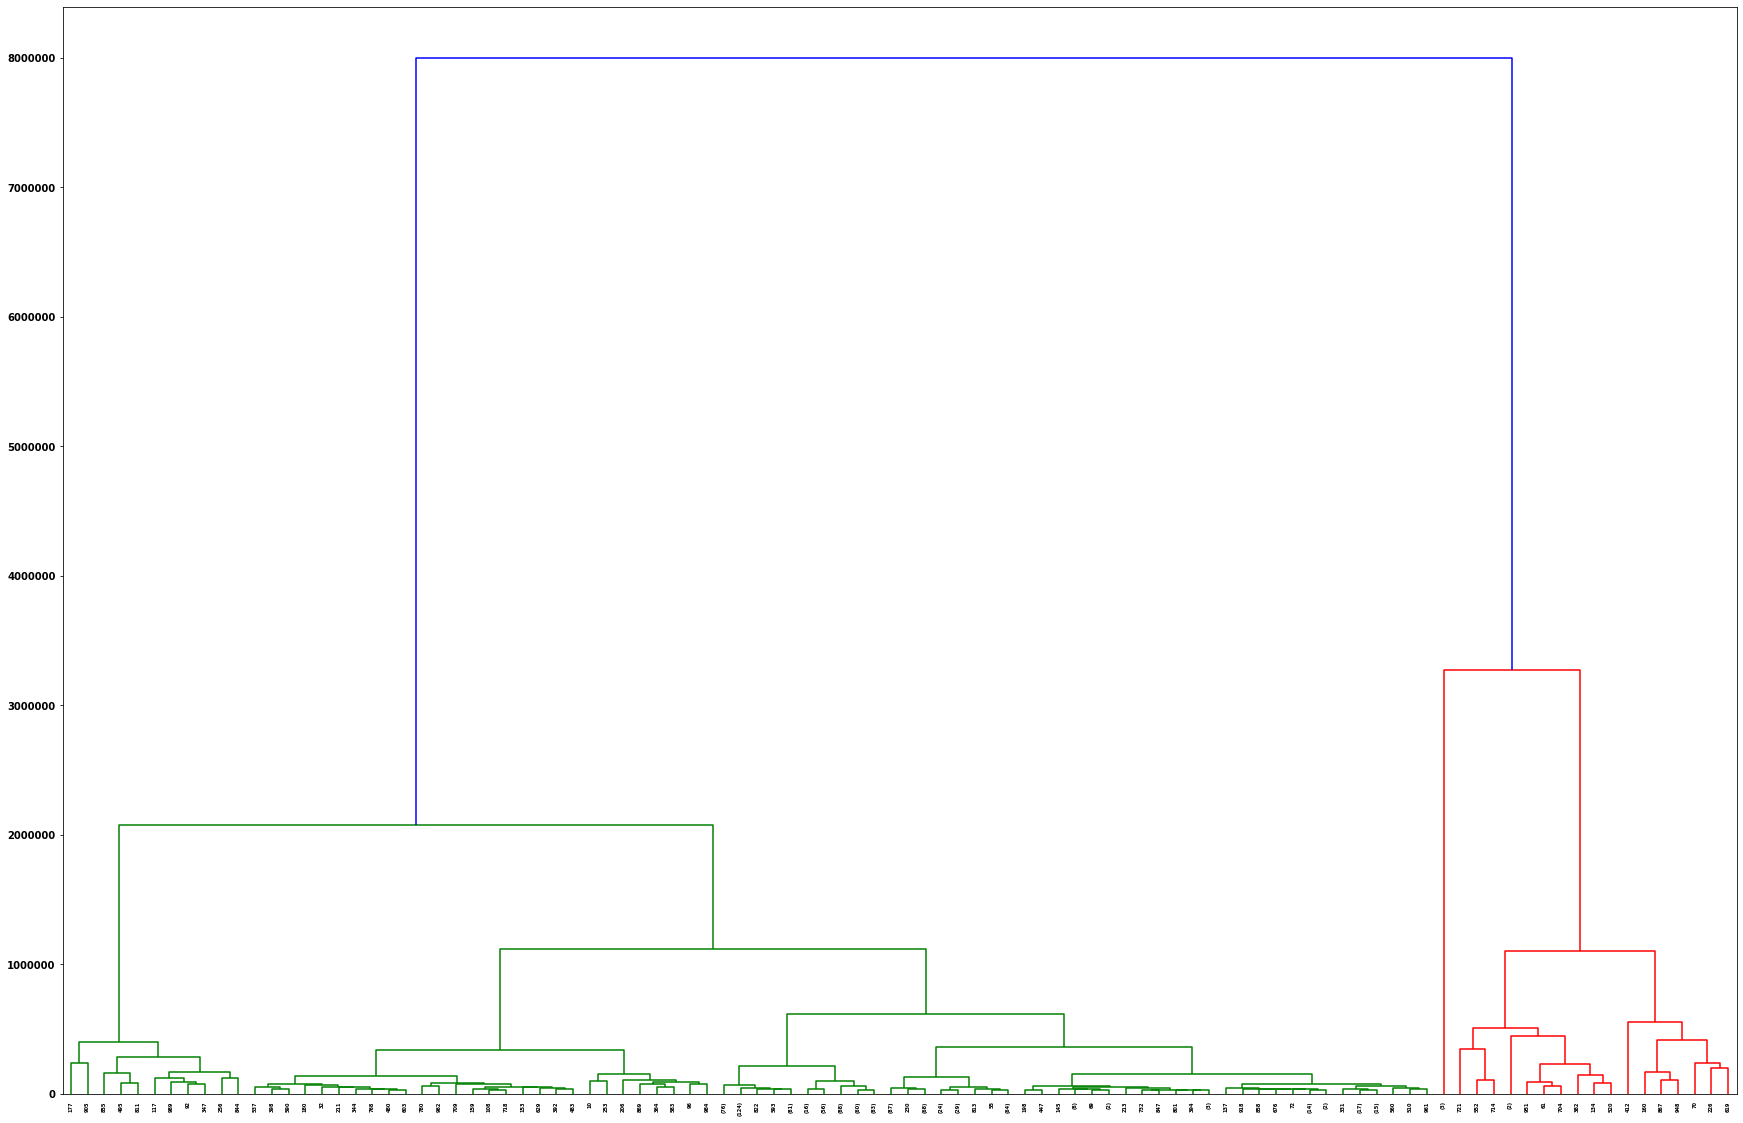

In [15]:
fig = plt.figure(figsize=(30, 20))
dn = scipy.cluster.hierarchy.dendrogram(clust, p=100, truncate_mode='lastp', show_leaf_counts=True)

In [16]:
clusterIDs = scipy.cluster.hierarchy.cut_tree(clust, 5).T[0]

In [17]:
ff = np.fft.fftfreq(10001, 0.001)

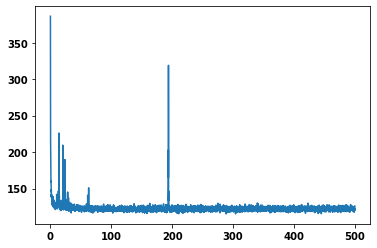

In [18]:
plt.plot(ff[ff > 0], np.mean(samplesFit[clusterIDs == 0], axis=0)[ff > 0])

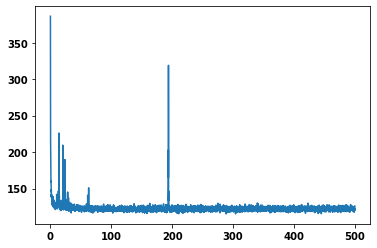

In [54]:
plt.plot(ff[ff > 0], np.mean(samplesFit[clusterIDs == 0], axis=0)[ff > 0])

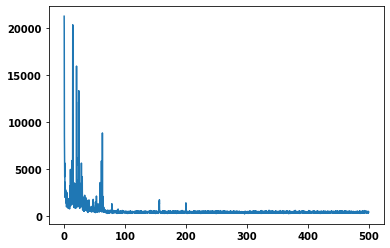

In [66]:
plt.plot(ff[ff > 0], np.mean(samplesFit[clusterIDs == 2], axis=0)[ff > 0])

In [20]:
import gc; gc.collect()

12

In [21]:
from sklearn.neighbors import NearestNeighbors

In [22]:
neigh = NearestNeighbors(n_neighbors=1, n_jobs=1).fit(samplesFit)

In [23]:
#t0 = time.time()
#nn = neigh.kneighbors(dataFFTflat, return_distance=False)
#nn = nn.T[0]
#t1 = time.time()
#t1 - t0

6722.950329780579

In [38]:
cl = scipy.cluster.hierarchy.cut_tree(clust, 5).T[0][nn].reshape((1024, 1024))

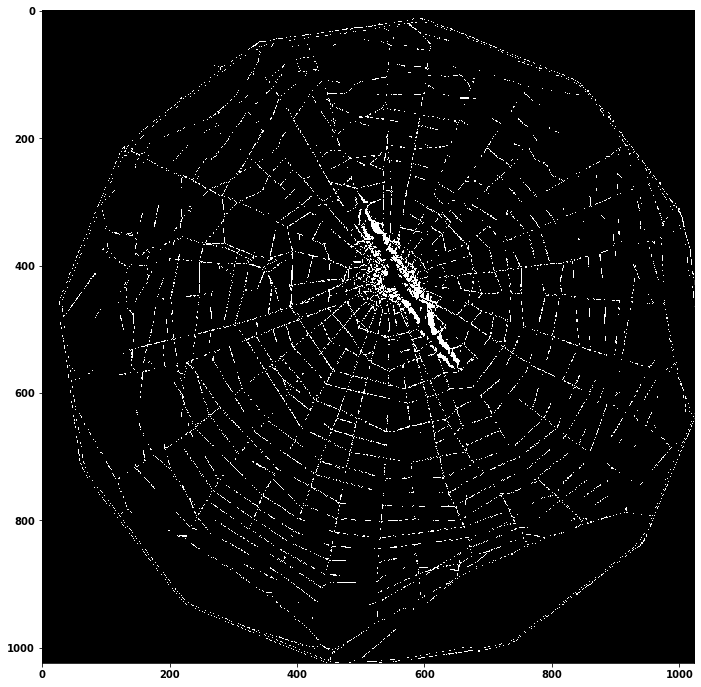

In [62]:
plt.figure(figsize=(12,12))
plt.imshow(cl == 1, cmap='gray')

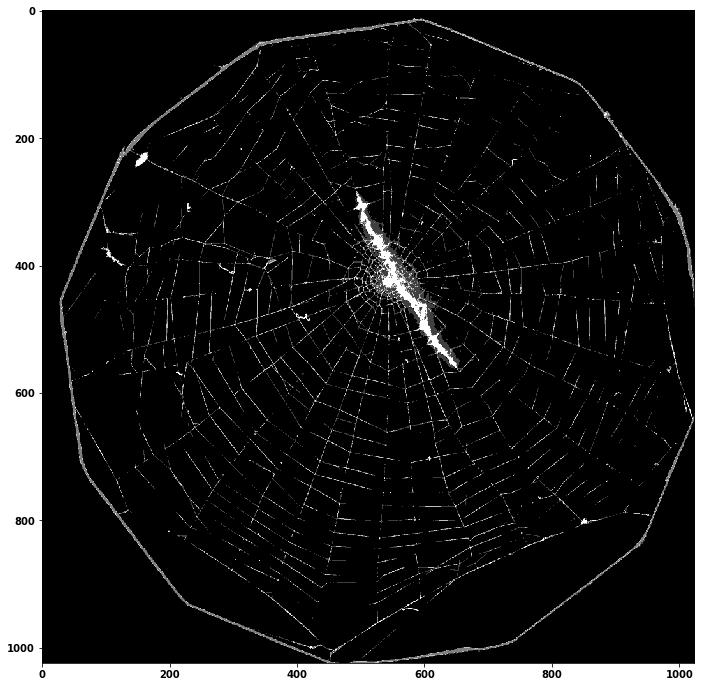

In [64]:
plt.figure(figsize=(12,12))
plt.imshow(cl, cmap='gray')

In [ ]:
plt.imshow()

In [223]:
vMean = np.mean(dataFFTflat[:,(ff > 100)&(ff < 300)], axis=1)
vMean.shape

(1048576,)

In [239]:
v = np.max(dataFFTflat[:,(ff > 199.5) & (ff < 201.5)], axis=1)
vi = (v > np.percentile(v, 95)) & (v/vMean > np.percentile(v/vMean, 95))

In [240]:
spec = dataFFTflat[vi,:]
spec.shape

(17277, 10001)

In [241]:
specSS = spec[np.random.choice(np.arange(spec.shape[0]), 100, replace=False),:]
specSS.shape

(100, 10001)

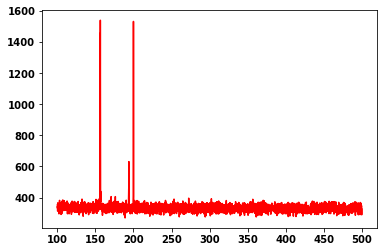

In [242]:
#plt.plot(ff[ff > 100], specSS[:,ff > 100].T)
plt.plot(ff[ff > 100], np.mean(specSS[:,ff > 100], axis=0), color='red')
plt.show()

In [243]:
ff

array([ 0.     ,  0.09999,  0.19998, ..., -0.29997, -0.19998, -0.09999])

In [114]:
data = np.load(fname + '.npy', mmap_mode='r')
data.shape

(1024, 1024, 10001)

In [244]:
ssData = data[vi.reshape((1024, 1024)),:]
ssData.shape

(17277, 10001)

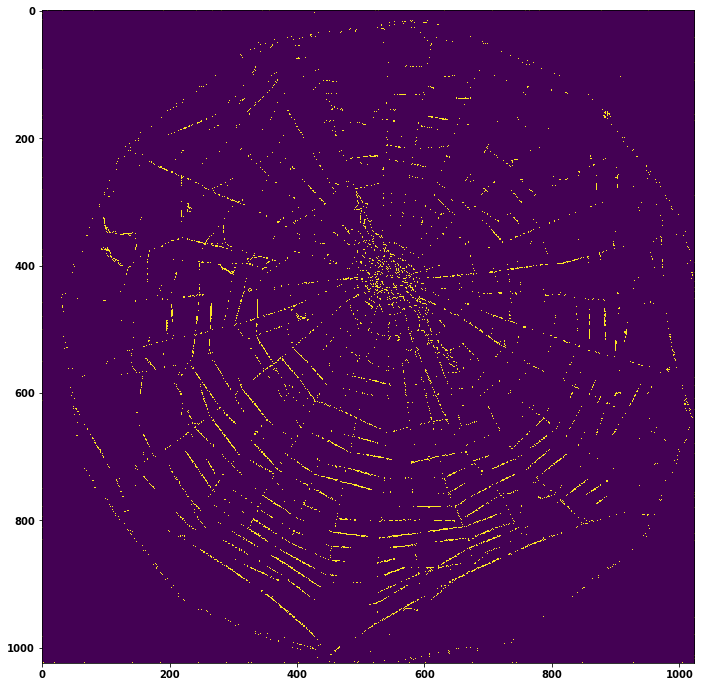

In [246]:
plt.figure(figsize=(12,12))
plt.imshow(vi.reshape((1024, 1024)))
#plt.imshow(scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(vi.reshape((1024, 1024)))))

In [212]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [264]:
_ss = np.random.choice(np.arange(ssData.shape[0]), 100, replace=False)
_ss

array([ 7081, 13536,  4995, 14536,  8179,  4526, 10259,  9385, 10292,
        1984, 13446,  2138, 14769, 13253, 10282,  8799, 11993,  1400,
       10827,  2272, 11274,  5043, 11023, 11654,  1978,  3155,  4904,
       13712,  5378, 13892, 11024, 12138,  9758, 11572, 12624, 15225,
       11150,  5782,  8716, 15876,  8678, 10959,   432, 11679, 10247,
       11606,  3729,  8585, 14857, 16996,  4436, 11155, 10319,   377,
       16200, 12354,  4855,  8194,  6781,  9062, 10793,  7948, 14746,
        8085,  9448,  4286, 10512,  8494,  6674,  5858, 16373,   105,
        7693,  2852,  3143,  8037,  7158,    13,  4070, 11062, 16308,
        9871,  9660,   134,  1988,   898,  5633,  5861, 15535,  6609,
        3557, 14531, 14501,  6782,  5333, 12787, 14098,  9203, 14980,
        1933])

In [ ]:
_ss = np.random.choice(np.arange(ssData.shape[0]), 1, replace=False)


In [267]:
def fn(s):
    window = slice(s, s + 1000)
    _ff = np.fft.fftfreq(window.stop - window.start, 0.001)
    _ffMin = 100
    _y = pd.DataFrame(np.mean(np.abs(scipy.fft(ssData[_ss,window], axis=1)), axis=0)).rolling(5).sum()
    plt.plot(
        _ff[_ff > _ffMin], 
        _y[_ff > _ffMin])
    
interact(fn, s=widgets.IntSlider(min=0, max=9000, step=1, value=5000));

interactive(children=(IntSlider(value=5000, description='s', max=9000), Output()), _dom_classes=('widget-inter…

### Now compute masks for each recording

### Now compute averaged FFT

In [56]:
ff = np.fft.fftfreq(data.shape[2], 0.001)

NameError: name 'data' is not defined

In [57]:
ff300 = np.mean(np.abs(dataFFT[:,:,(ff > 299) & (ff < 301)]), axis=2)
ff200 = np.mean(np.abs(dataFFT[:,:,(ff > 199) & (ff < 201)]), axis=2)
ff100 = np.mean(np.abs(dataFFT[:,:,(ff >  99) & (ff < 101)]), axis=2)

NameError: name 'dataFFT' is not defined

In [ ]:
webMask = np.mean(data, axis=2)

In [ ]:
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow((webMask > 24)&(webMask < 64))

In [ ]:
dataFFT.shape

In [ ]:
ftWeb  = np.mean(dataFFT[(webMask > 24)&(webMask < 64)], axis=0)
import gc; gc.collect()

In [ ]:
ftWebMax  = np.max(dataFFT[(webMask > 24)&(webMask < 64)], axis=0)
import gc; gc.collect()

In [ ]:
plt.figure(figsize=(10,6), facecolor='w')
plt.plot(ff[ff > 0], ftWeb[ff > 0], color='red')
#plt.plot(ftNWeb, color='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10,6), facecolor='w')
plt.plot(ff[ff > 0], ftWebMax[ff > 0], color='red')
#plt.plot(ftNWeb, color='gray')
plt.title('Freq = {}'.format(freq))
plt.show()

In [ ]:
plt.figure(figsize=(10,6), facecolor='w')
plt.plot(ff[ff > 0], ftWebMax[ff > 0], color='red')
#plt.plot(ftNWeb, color='gray')
plt.show()